## Homework 2

**Submitted by : Tanvi Arora**   
**Section     : DS 7337 Natural Language Processing - 401**

<a id="top"></a>
### Contents

* <a href="#Webscraping">Web Data Fetch</a>
* <a href="#VocabNormalize">Problem 1 : Scoring and Normalizing Vocabulary size </a>
* <a href="#LongWordsVocabNormalize">Problem 2 : Scoring and Normalizing Long-words Vocabulary size</a>
* <a href="#TextDifficultyScore">Problem 3 : Text-Difficulty score</a>
* <a href="#TextScoring">Text-scoring All Methods</a>
* <a href="#FunctionCall">Calling all functions</a>
* <a href="#TextScoreAnalysis">Text Score Analysis </a>

In [90]:
import platform
print(platform.platform())

import sys
print("Python",sys.version)

import nltk
from nltk.tokenize import regexp_tokenize
print("nltk",nltk.__version__)

from bs4 import BeautifulSoup
import requests
import urllib
import re
import pandas as pd
from tabulate import tabulate
from urllib import request
from __future__ import division, unicode_literals
from math import sqrt
import matplotlib.pyplot as plt

MIN_CHAR_LEN=15
START_TAG_POS_LIMIT=13000

Windows-10-10.0.17134-SP0
Python 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
nltk 3.4.1


<a id="Webscraping"></a>
<a href="#top">Back to Top</a>
### Reusable functions to read webpage

In [134]:
## returns webpage content if web page accessible else None
def getSoup(url):
    grab_page = requests.get(url,timeout=5)
    if grab_page.status_code != 200:
        return None
    else:
        return BeautifulSoup(grab_page.content, "html5lib")

## returns bookname in proper format and link of the format requested
## input : beautiful soup page content, bookformat : "html" or "utf8"
def getBookdetails(childsoup,bookformat):
    bookname=[]
    
    child_body = child_soup.find('div', id="download")
    link_table = child_body.table
    ## get title of book
    metalist=child_soup.head.find_all("meta")
    
    for m in metalist:
        if m.get("name", None) == "title":
            bookname.append(m.get("content", None))
    
    if bookformat=="html":
        booktype="text/html"
    elif bookformat=="utf8":
        booktype="text/plain"
    
    #htmllinklist=[]
    #utf8linklist=[]
    ## get book links
    for l in link_table.find_all('tr'):
        column=l.find_all('td')
        for rc in column:
            booklinktag = rc.findAll(title="Download", type=re.compile(booktype))
            if (booklinktag):
                for h in booklinktag:
                    if(h.attrs["href"]):
                        #htmllinklist.append(h.attrs["href"])
                        booklink= h.attrs["href"]
                    else:
                        booklink=None

    #print(bookname)
    return bookname,booklink


## basic beautiful soup read function 
def read_html(url):
    html = request.urlopen(url).read().decode('utf8')
    raw = BeautifulSoup(html, 'html.parser').get_text()
    tokens = word_tokenize(raw)
    text = nltk.Text(tokens)
    return text

## basic utf8 text read function using requests
def read_utf8(url):
    response = request.urlopen(url)
    raw = response.read().decode('utf8')
    tokens = nltk.word_tokenize(raw)
    #text = nltk.Text(tokens)
    return raw

## returns position of the regular expression in the text
## if not found returns -1
def getPosition(text,pattern):
    regex=re.compile(pattern,re.IGNORECASE)
    if regex.search(text) == None:
        return -1
    else:
        return regex.search(text).span()[0]
    
'''
    Identified few start phrases based on manual views of some of the textbooks
    Used regular Expressions to capture majority of start expressions
    Some of the regular expressions threw off to the book content which
    was reviewed by looking at the start positions of each of the start phrase for all books
    and a reasonable start position limit of 13000 was identified. Since we considering maximum
    position amongst all the start phrases, all start positions > 13000
    are ignored and next highest start position is considered as start position
    If start position is not obtained based on available start phrases,
    it is defaulted to 1
'''
def get_StartPosition(rawtext):
    p1=getPosition(rawtext,'PREFACE*.*[\s.]')
    if p1>START_TAG_POS_LIMIT:
        p1=-2
    p2=getPosition(rawtext,'INDEX[\s.]')
    if p2>START_TAG_POS_LIMIT:
        p2=-2
    p3=getPosition(rawtext,'START OF THE PROJECT GUTENBERG')
    if p3>START_TAG_POS_LIMIT:
        p3=-2
    p4=getPosition(rawtext,'Contents*.*[\s.]')
    if p4>START_TAG_POS_LIMIT:
        p4=-2
    p5=getPosition(rawtext,'Illustration*.*[\s.]')
    if p5>START_TAG_POS_LIMIT:
        p5=-2
    start=max(p1,p2,p3,p4,p5)
    if start<0:
        return 1
    else:
        return start

#normalize words by removing numbers and punctuations and convert all words to lower case to remove duplicates later
def text_norm(text):
    words=[word.lower() for word in text if word.isalpha()]
    return words
    

# print tabular output
def tab_bookstats(book_pd):
    print(tabulate(book_pd, headers='keys', tablefmt='simple',showindex=False,))
    
def get_textbook_contentonly(url):
    rawtext=read_utf8(url)
    # identify the start position to remove Gutenberg license and other
    # non-content information from vocabulary
    startpos=get_StartPosition(rawtext)
    # identify end tag position to remove Gutenberg licenses from vocabulary
    if rawtext.rfind("End of the Project Gutenberg") != -1:
        endpos=rawtext.rfind("End of the Project Gutenberg")
    elif rawtext.rfind("End of Project Gutenberg's") != -1:
        endpos=rawtext.rfind("End of Project Gutenberg's")
    elif rawtext.rfind("END OF THE PROJECT GUTENBERG") != -1:
        endpos=rawtext.rfind("END OF THE PROJECT GUTENBERG")
    elif rawtext.rfind("END OF THIS PROJECT GUTENBERG") != -1:
        endpos=rawtext.rfind("END OF THIS PROJECT GUTENBERG")
    else:
        endpos=len(rawtext)
    tokens = nltk.word_tokenize(rawtext[startpos:endpos])
    text = nltk.Text(tokens)
    return text

def get_textbooks(url_list):
    text=[]
    for u in url_list:
        #print("http:"+u)
        #print("=====================================")
        text.append(text_norm(get_textbook_contentonly("http:"+u)))
    
    return text

   

<a id="VocabNormalize"></a>
<a href="#top">Back to Top</a>
### Normalization functions

In [3]:
## lexical diversity is a measure of how many different words that are used in a text
def lexical_diversity(text):
    return len(set(text))/len(text)

def percentage(word,text):
    return 100* text.count(word)/len(text)

## vocabulary is the list of distinct words used in a text
def vocab(tokens):
    return set(tokens)

## raw score is a normalized vocabularysize score having a range of values in 0,1
def get_raw_score(vocabsizelist):
    max_size=max(vocabsizelist)
    return [vc/max_size for vc in vocabsizelist]

## sqrt score is the sqrt of normalized score    
def get_sqrt_score(rawscorelist):
    return [sqrt(raw_sc) for raw_sc in rawscorelist]

## normalized final score
## returns average of sqrt score and rank score. 
## To note : sqrt score is a function of normalized vocab size
def get_norm_final_score(sqrt_score,rank_score):
    return (1/2)*(sqrt_score+rank_score)

We are analyzing multiple books and it is necessary to have a common scale for comparision. Lexical Diversity is a measure of the book only and hence normalized scores for vocabulary are required. A simple normalization ( function : get_raw_score )
will normalize the vocabulary size of each book .This score will change if the list of books being considered changes.

*raw_score = vocabulary_size of book / maximum vocabulary_size in the list of books*

*sqrt_score is a square root of the raw score.*

*rank score is the rank of the book based on ascending size of the vocabulary_size i.e. lower rank for books with lower vocabulary size and to normalize this score, we divide it by the number of total books*

**A normalized final score that is considered for all analysis is (1/2) * (sqrt_score + rank score )**

<a id="LongWordsVocabNormalize"></a>
<a href="#top">Back to Top</a>
### Long-word scoring

In [158]:
## identify size of long-words in a text
## accepts min_char_len , length beyond which is considered as long-word
def get_long_words_vocab_size(text,min_char_len):
    long_words=[]
    words=set(text)
    long_words=[w for w in words if len(w) > min_char_len]
    return len(long_words)



Above function returns the length of long words in a book. For this analysis, long-word minimum length is set to 15 characters. 
Once the long_word vocabulary size is obtained for each book, normalization functions used in problem#1 for vocabulary size are applied to this value also

<a id="TextDifficultyScore"></a>
<a href="#top">Back to Top</a>
### Text-difficulty score

In [5]:
## text difficulty score is the equal-weighted score of the 3 text scores
def get_text_difficulty_score(lex_div,norm_vocab,norm_long_words):
    return (1/3)*(lex_div+norm_vocab+norm_long_words)
    

Major scores that we have considered are :  
i) lexical diversity  
ii) normalized vocabulary score  
iii) normalized long-word vocabulary score  

Text difficulty function is created by considering equal weightage of each of above scores.


<a id="TextScoring"></a>
<a href="#top">Back to Top</a>
### Text scoring function

Below is the function definition of all the text scores for a book. Since some scores are dependent on all the books being considered, this function takes book list instead of individual book as input

In [145]:
'''
for a given list of texts, apply all text-score functions
returns a dataframe of utf8-link and below scores :
 i) lexical diversity
 ii)vocabulary size
 iii)raw score
 iv) sqrt score
 v) rank score
 vi) long words vocabulary size
 vii) long words raw score
 viii) long words sqrt score
 ix) long words rank score
 x) normalized vocab score
 xi) long words normalized vocab score
 xii) text difficulty score

for the long_Words detection, min_char_length is set to 15
'''
def get_text_scores(text_list):
    lexdiv_list=[]
    vocab_size_list=[]
    long_words_list=[]
    raw_score_list=[]
    long_words_raw_score_list=[]
    score_sqrt_list=[]
    long_words_score_sqrt_list=[]
    
    for t in text_list:
        lexdiv_list.append(lexical_diversity(t))
        vocab_size_list.append(len(vocab(t)))
        long_words_list.append(get_long_words_vocab_size(t,MIN_CHAR_LEN))
    
   
    raw_score_list=get_raw_score(vocab_size_list)
    long_words_raw_score_list=get_raw_score(long_words_list)
    
    score_sqrt_list=get_sqrt_score(raw_score_list)
    long_words_score_sqrt_list=get_sqrt_score(long_words_raw_score_list)
    
    book_df=pd.DataFrame({'utf8_link' : ullist,
                         'lexical_diversity' : lexdiv_list,
                         'vocab_size' : vocab_size_list,
                         'raw_score' : raw_score_list,
                         'score_sqrt' : score_sqrt_list,
                         'long_words' : long_words_list,
                         'long_words_raw_score' : long_words_raw_score_list,
                         'long_words_score_sqrt' : long_words_score_sqrt_list})

    # higher rank is given to the book with more vocab_size

    book_df['rank_score']=book_df["vocab_size"].rank(ascending=1,method='average')/len(text_list)
    book_df['long_words_rank_score']=book_df["long_words"].rank(ascending=1,method='average')/len(text_list)
    book_df['norm_final_score']=book_df.apply(lambda row : get_norm_final_score(row['score_sqrt'], row['raw_score']), axis=1 )
    book_df['long_words_norm_final_score']=book_df.apply(lambda row : get_norm_final_score(row['long_words_score_sqrt'], row['long_words_raw_score']), axis=1 )
    book_df['text_difficulty_score']=book_df.apply(lambda row : get_text_difficulty_score(row['lexical_diversity'], row['norm_final_score'], row['long_words_norm_final_score']), axis=1 )
    
    return book_df

    
### combined function to fetch book links and get their text scores
def text_scores(url_list):
    textlist=[]
    textlist=get_textbooks(url_list)
    return get_text_scores(textlist)
    

<a id="FunctionCall"></a>
<a href="#top">Back to Top</a>
### Main program

In [7]:
# call the main URL
soup=getSoup("http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)")

In [9]:
# Extract book links from the main web page
booklink=[l.attrs["href"]  for l in soup.find(class_="mw-parser-output").find_all('a',class_="extiw")]

In [159]:
print("number of books obtained from main url ",len(booklink))

number of books obtained from main url  104


In [11]:
#Get 'UTF-8' format book links for each of the book
bnlist=[]
ullist=[]

for l in booklink:
    #print("http"+l)
    #print("======================================================")
    child_soup=getSoup("http:"+l)
    bn,ul=getBookdetails(child_soup,'utf8')
    bnlist.append(bn)
    ullist.append(ul)

if len(bnlist)==len(booklink):
    print("We are good to go")
else:
    print("some links maybe broken")

We are good to go


In [116]:
# get all texts for text books to minimize web read

textbooks=[]
textbooks=get_textbooks(ullist)
#textbooks=read_utf8(ullist)


if len(textbooks)==len(bnlist):
    print("We are good to go")
else:
    print("some links maybe broken")

We are good to go


In [143]:
# perform score functions on the text books data
book_textscores_df=get_text_scores(textbooks)

In [147]:
book_textscores_df["bookname"] = bnlist
book_textscores_viz_df=  book_textscores_df.loc[:,["bookname","lexical_diversity","norm_final_score","long_words_norm_final_score","text_difficulty_score"]]
print(tabulate(book_textscores_viz_df, headers='keys', tablefmt='simple',showindex=False,))

bookname                                                                                   lexical_diversity    norm_final_score    long_words_norm_final_score    text_difficulty_score
---------------------------------------------------------------------------------------  -------------------  ------------------  -----------------------------  -----------------------
['A Primary Reader: Old-time Stories, Fairy Tales and Myths Retold by Children']                   0.101331            0.149702                       0                        0.0836778
['The Bird-Woman of the Lewis and Clark Expedition by Katherine Chandler']                         0.121435            0.18915                        0                        0.103529
["Dr. Scudder's Tales for Little Readers, About the Heathen. by John Scudder"]                     0.109802            0.42725                        0                        0.179017
['The Louisa Alcott Reader: a Supplementary Reader for the Fourth Year of Sch

<a id="TextScoreAnalysis"></a>
<a href="#top">Back to Top</a>
### Text score Analysis

#### Top 5 books with highest lexical diversity

In [148]:
book_textscores_viz_df.sort_values(by=["lexical_diversity"], axis=0 , ascending=False  ) \
                      .head(5)[["bookname","lexical_diversity"]]

,bookname,lexical_diversity
81,[A Manual of Pronunciation by Otis Ashmore],0.585272
10,[Little Present by Unknown],0.514377
48,[Child's Book of Water Birds by Anonymous],0.513382
46,[Book about Animals by Rufus Merrill],0.431159
101,[A Little Book for A Little Cook by L. P. Hubb...,0.382480


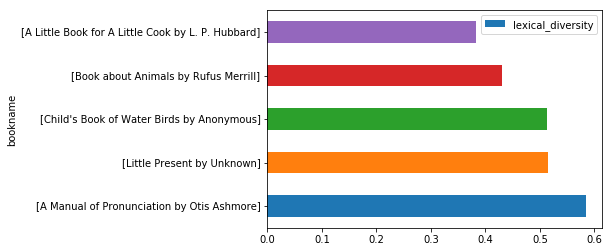

In [149]:
book_textscores_viz_df.sort_values(by=["lexical_diversity"], axis=0 , ascending=False  ) \
                      .head(5) \
                      .plot(kind='barh', x='bookname' , y='lexical_diversity')

*_Highest lexical diversity is close to 0.58, looking at top 5 books based on their lexical diversity, they are quiet close_*

#### Top 5 books with highest normalized vocabulary score

In [150]:
book_textscores_viz_df.sort_values(by=["norm_final_score"], axis=0 , ascending=False  ) \
                      .head(5)[["bookname","norm_final_score"]]

,bookname,norm_final_score
21,[McGuffey's Sixth Eclectic Reader by William H...,1.000000
26,"[The Ontario Readers: The High School Reader, ...",0.963109
71,"[A Modern History, From the Time of Luther to ...",0.939409
29,[Sanders' Union Fourth Reader by Charles W. Sa...,0.882032
20,[McGuffey's Fifth Eclectic Reader by William H...,0.834973


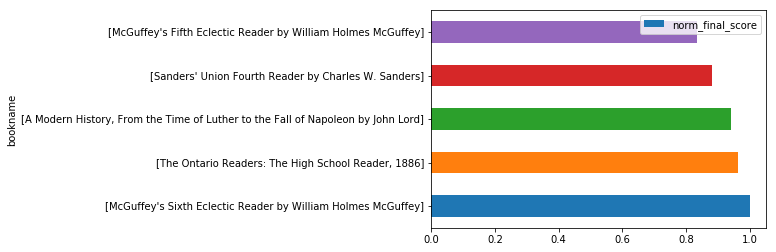

In [151]:
book_textscores_viz_df.sort_values(by=["norm_final_score"], axis=0 , ascending=False  ) \
                      .head(5) \
                      .plot(kind='barh', x='bookname' , y='norm_final_score')

*_Normalized score is between 0 and 1 , and is based on the list of books being considered, so highest value obtained is 1 definitely. Looking at the top 5 books based on normalized vocabulary score, they are quiet close to each other. However interesting to note is the books with top 5 normalized vocabulary size are different than the top 5 books based on the lexical diversity_*

#### Top 5 books with highest normalized long-word vocabulary score

In [152]:
book_textscores_viz_df.sort_values(by=["long_words_norm_final_score"], axis=0 , ascending=False  ) \
                      .head(5)[["bookname","long_words_norm_final_score"]]

,bookname,long_words_norm_final_score
53,[Dierenleven in de wildernis by William J. Long],1.000000
96,[Leçons de cosmographie by Adrien Guilmin],0.534969
71,"[A Modern History, From the Time of Luther to ...",0.511509
26,"[The Ontario Readers: The High School Reader, ...",0.413751
38,[First Italian Readings by Various],0.334679


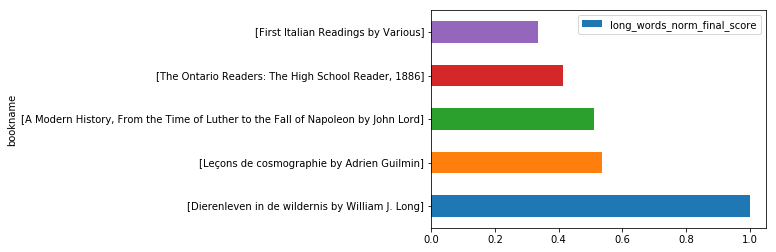

In [153]:
book_textscores_viz_df.sort_values(by=["long_words_norm_final_score"], axis=0 , ascending=False  ) \
                      .head(5) \
                      .plot(kind='barh', x='bookname' , y='long_words_norm_final_score')

*_We have considered 15 char length as the lower limit of long-words . This analysis may change if the minimum length criteris is changed, more for the lower value than the higher. Normalized score is between 0 and 1 , and is based on the list of books being considered, so highest value obtained is 1 definitely. Looking at the top 5 books based on long-words normalized vocabulary score, it is a skewed plot with 1 book having the maximum number of long-words and second book to top it has 40% less long words. Also interesting to note is the books with top 5 long-words normalized vocabulary size are different than the top 5 books based on the lexical diversity but these have some common traits with the top 5 books of normalized vocabulary score_*

**_The book with highest number of long-words is a Dutch book. We have not considered any translations for this analysis and for this book vocabulary is in Dutch. Language plays a factor in this case as Dutch language itself may have more long word as compared to English or other language_**

#### Top 5 books with highest text-difficulty score

In [154]:
book_textscores_viz_df.sort_values(by=["text_difficulty_score"], axis=0 , ascending=False  ) \
                      .head(5)[["bookname","text_difficulty_score"]]

,bookname,text_difficulty_score
53,[Dierenleven in de wildernis by William J. Long],0.545906
71,"[A Modern History, From the Time of Luther to ...",0.503514
26,"[The Ontario Readers: The High School Reader, ...",0.494266
38,[First Italian Readings by Various],0.480031
21,[McGuffey's Sixth Eclectic Reader by William H...,0.438193


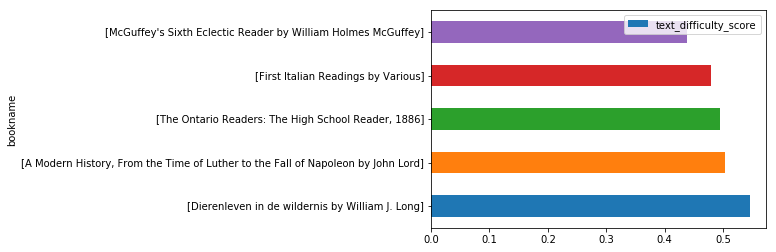

In [155]:
book_textscores_viz_df.sort_values(by=["text_difficulty_score"], axis=0 , ascending=False  ) \
                      .head(5) \
                      .plot(kind='barh', x='bookname' , y='text_difficulty_score')

*_Text difficulty score tend to be biased towards the normalized vocabulary scores for all words plus long-words.None of the books with top lexical diversity are in the list of top 5 books with high difficulty score. As we know from our previous analysis that the 2 normalized scores have ranges , they affect the text difficulty score. But the text difficulty score is in the range similar to lexical diversity i.e. 0 to 0.6 and the top 5 books are not to far away from each other._*

### Summarized view of all scores for all books

In [156]:
book_textscores_viz_df["book#"]=list(book_textscores_viz_df.index)

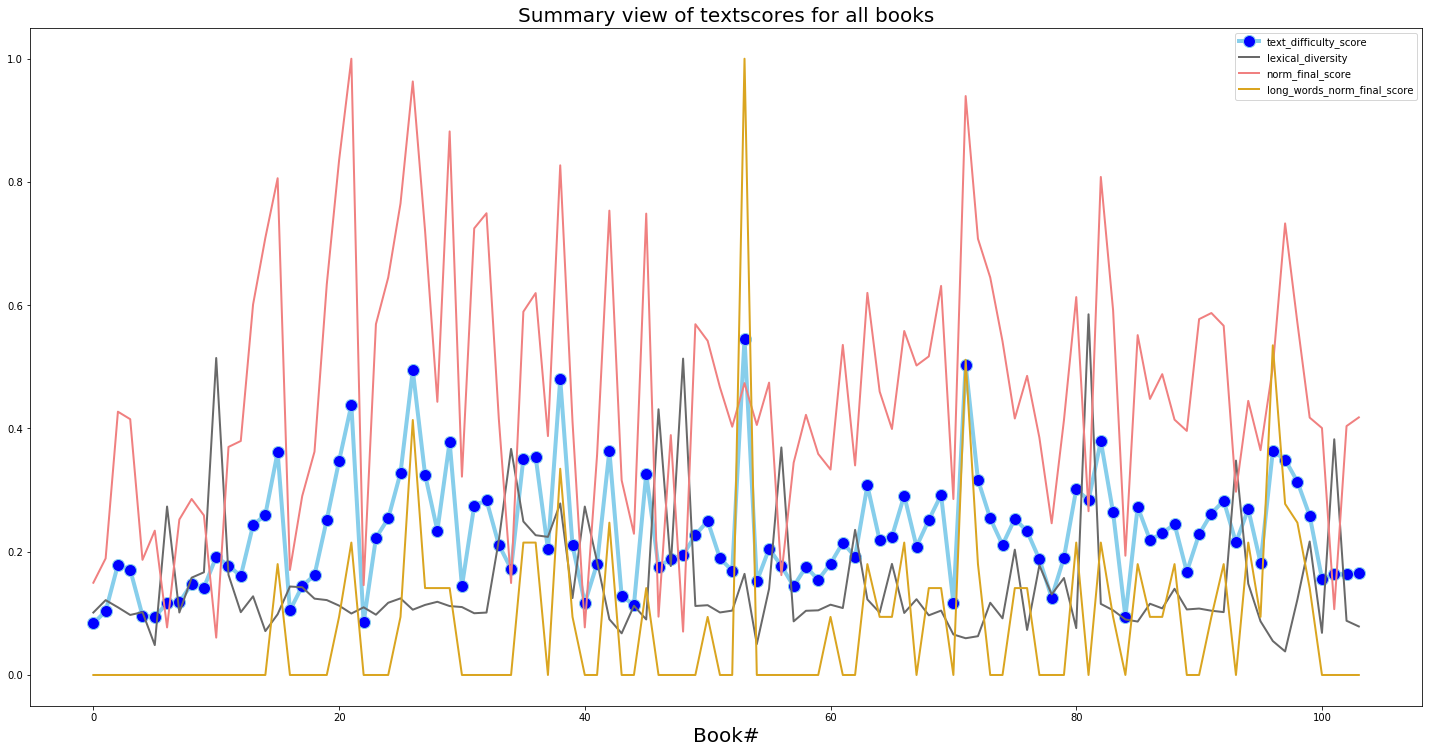

In [157]:

# multiple line plot
plt.figure(figsize=(20,10))
plt.plot( 'book#', 'text_difficulty_score', data=book_textscores_viz_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'book#', 'lexical_diversity', data=book_textscores_viz_df, marker='', color='dimgrey', linewidth=2)
plt.plot( 'book#', 'norm_final_score', data=book_textscores_viz_df, marker='', color='lightcoral', linewidth=2)
plt.plot( 'book#', 'long_words_norm_final_score', data=book_textscores_viz_df, marker='', color='goldenrod', linewidth=2)
plt.tight_layout()
plt.title("Summary view of textscores for all books",fontsize=20)
plt.xlabel("Book#", fontsize=20)
plt.legend()


**From the graph above**

1) For most of the books, normalized vocabulary score is high as compared to their lexical diversity. There are few exceptions though where lexical diversity is higher than the normalized vocabulary score. These are the books that are rich in their lexical diversity individually but when compared with other books on the Gutenberg project, these are not as rich in vocabulary.

2) The book with highest text difficulty score has lower lexical diversity but a very high long words raw score, i.e. uses a lot of long words ( words with length > 15 ). This increases its text difficulty level. Similarly there are books with 0 long-words , per our pre-assumed long-word length as 15 characters. This brings down its text difficulty score when compared to other books. This can change if our pre-assumed long-word length changes.

3) To be noted there are many books that do not have words that are larger than 15 characters